# Move recommendations

In [31]:
import json
import random
import subprocess
import sys

import chess.engine
import pandas as pd

In [32]:
df = pd.read_parquet('data/moves_2025_01.parquet')
df.tail()

,avg_elo,moves,winner
4990819,1553.0,e2e4 d7d5 e4d5 d8d5 b1c3 d5e6 f1e2 b8c6 g1f3 g...,1
4990836,1960.0,e2e4 d7d5 e4d5 d8d5 d2d4 g8f6 c1e3 c8g4 f1e2 b...,1
4990890,817.5,e2e4 d7d5 e4d5 d8d5 d2d3 d5d4 c2c3 d4e5 f1e2 c...,2
4991060,1251.0,e2e4 d7d5 e4d5 d8d5 d2d4 g8f6 b1c3 g7g6 c3d5 f...,1
4991095,1889.5,e2e4 d7d5 e4d5 d8d5 g1f3 c8g4 f1e2 b8c6 e1g1 e...,1


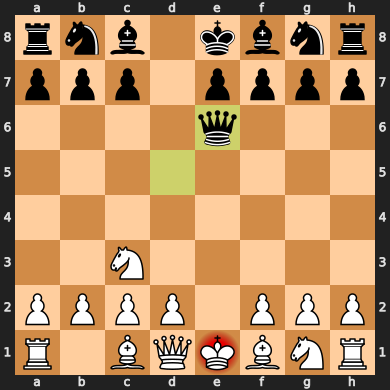

In [33]:
sample_row = df.sample(1).iloc[0]
moves_arr = sample_row['moves'].split()
# cutoff = min(random.randint(5, len(moves_arr) - 1), 10)
moves = moves_arr[:6]

board = chess.Board()
for uci in moves:
    board.push_uci(uci)

board

In [34]:
prefix = ' '.join(moves)
mask = df['moves'].str.startswith(prefix)

num_games = mask.sum()
num_white_wins = (df.loc[mask, 'winner'] == 1).sum()
winrate_white = num_white_wins / num_games if num_games > 0 else 0
avg_elo_current = int(df.loc[mask, 'avg_elo'].mean()) if num_games > 0 else 0

print(f"Times played: {num_games}")
print(f"Winrate in this position (white): {winrate_white:.2%}")
print(f"Average Elo of players: {avg_elo_current}")

Times played: 12591
Winrate in this position (white): 50.05%
Average Elo of players: 1405


In [35]:
results = []
for move in board.legal_moves:
    uci = move.uci()
    prefix2 = f"{prefix} {uci}"
    mask2 = df['moves'].str.startswith(prefix2)
    num = mask2.sum()
    if num > 0:
        wins = (df.loc[mask2, 'winner'] == 1).sum()
        winrate = wins / num
        elo_mean = int(df.loc[mask2, 'avg_elo'].mean())
    else:
        winrate, elo_mean = 0, 0
    results.append({
        'move': uci,
        'count': num,
        'winrate': winrate,
        'avg_elo': elo_mean
    })

df_next = (
    pd.DataFrame(results)
    .query("count > 100")
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

df_next

,move,count,winrate,avg_elo
0,f1e2,7625,0.513836,1400
1,d1e2,3403,0.471055,1442
2,g1e2,1511,0.500993,1346


In [36]:
if len(df_next) == 0:
    print("NOT ENOUGH DATA")

In [37]:
fen = board.fen()
moves = str(df_next['move'].tolist())

proc = subprocess.run(
    [sys.executable, 'evaluate_engine.py', fen, moves],
    capture_output=True,
    text=True
)

if proc.returncode != 0:
    raise RuntimeError(f"Engine script failed: {proc.stderr}")

engine_results = json.loads(proc.stdout)
engine_df = pd.DataFrame(engine_results)

df_stats = df_next.merge(engine_df, on='move')
df_stats

,move,count,winrate,avg_elo,delta,complexity
0,f1e2,7625,0.513836,1400,110,0.348522
1,d1e2,3403,0.471055,1442,18,0.403941
2,g1e2,1511,0.500993,1346,73,0.458128


In [38]:
proc2 = subprocess.run(
    [sys.executable, 'global_best.py', fen],
    capture_output=True,
    text=True
)

if proc.returncode != 0:
    raise RuntimeError(f"Engine script failed: {proc2.stderr}")

global_best_move = proc2.stdout
print("Engine recommended best move:", global_best_move)

Engine recommended best move: f1e2



In [39]:
ELO_DEVIATION = 0.30
min_elo = int(df["avg_elo"].min())
max_elo = int(df["avg_elo"].max())
sample_elos = random.sample(range(min_elo, max_elo + 1), 5)
df_stats_filtered = df_stats[['move', 'delta', 'complexity']]
COMPLEXITY_WEIGHT_MAX = 0.3
RATING_WEIGHT = 0.3

In [40]:
def analyze_moves(data, data_stats, e):
    data_stats = data_stats.copy()
    for idx, mv in data_stats.iterrows():
        mv_uci = mv['move']
        prefix3 = f"{prefix} {mv_uci}"
        mask3 = data['moves'].str.startswith(prefix3)

        low = e * (1 - ELO_DEVIATION)
        high = e * (1 + ELO_DEVIATION)
        mask4 = mask3 & data['avg_elo'].between(low, high)

        num2 = mask4.sum()
        if num2 > 0:
            wins2 = (data.loc[mask4, 'winner'] == 1).sum()
            winrate2 = wins2 / num2
        else:
            winrate2 = 0.50

        data_stats.at[idx, 'winrate'] = winrate2

    complexity_weight = COMPLEXITY_WEIGHT_MAX if elo <= 1000 else max(0.0,
                                                                      COMPLEXITY_WEIGHT_MAX * (1 - (elo - 1000) / 1000))
    rating_weight = RATING_WEIGHT
    histo_weight = 1 - complexity_weight - rating_weight

    scaler = MinMaxScaler()
    data_stats[['rating_scaled', 'complexity_scaled', 'winrate_scaled']] = scaler.fit_transform(
        data_stats[['delta', 'complexity', 'winrate']]
    )

    data_stats['complexity_scaled'] = 1 - data_stats['complexity_scaled']

    data_stats['score'] = (
            rating_weight * data_stats['rating_scaled'] +
            complexity_weight * data_stats['complexity_scaled'] +
            histo_weight * data_stats['winrate_scaled']
    )

    data_score = data_stats.sort_values("score", ascending=False)
    return data_score

In [41]:
for elo in sorted(sample_elos):
    df_score = analyze_moves(df, df_stats_filtered, elo)
    best_move = df_score['move'].iloc[0]
    print(f"Best move for ELO {elo}:\t{best_move}")

Best move for ELO 827:	f1e2
Best move for ELO 846:	f1e2
Best move for ELO 1001:	f1e2
Best move for ELO 1144:	f1e2
Best move for ELO 2153:	f1e2


In [42]:
df_score  # noqa

,move,delta,complexity,winrate,rating_scaled,complexity_scaled,winrate_scaled,score
0,f1e2,110,0.348522,0.489666,1.000000,1.000000e+00,0.854178,0.897924
2,g1e2,73,0.458128,0.495025,0.597826,-4.440892e-16,1.000000,0.879348
1,d1e2,18,0.403941,0.458272,0.000000,4.943820e-01,0.000000,0.000000


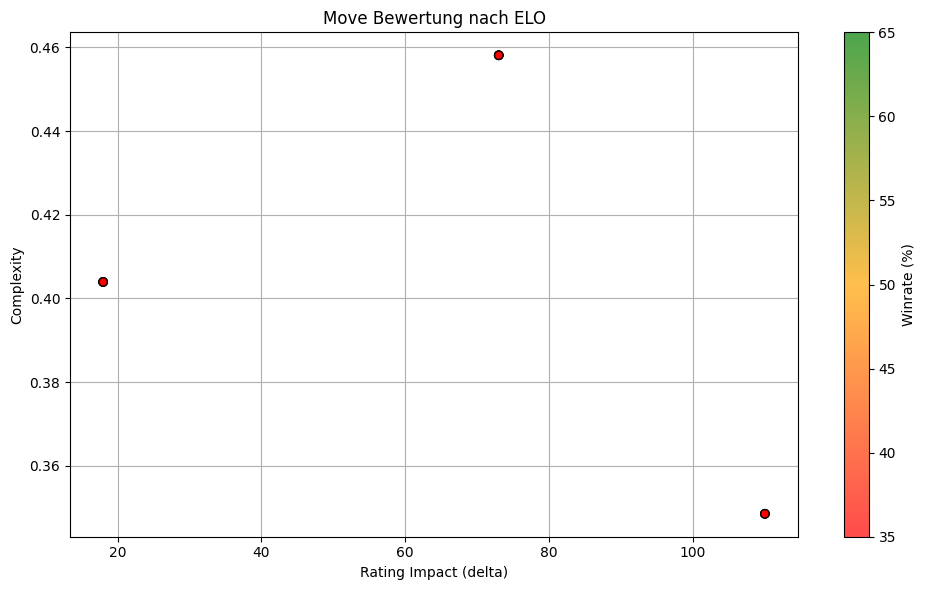

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import MinMaxScaler

# Ergebnisse sammeln
all_scores = []

for elo in sorted(sample_elos):
    df_score = analyze_moves(df, df_stats_filtered.copy(), elo)
    df_score['elo'] = elo
    all_scores.append(df_score)

# In eine Tabelle zusammenführen
df_results = pd.concat(all_scores, ignore_index=True)

# Farbschema definieren: 35% = rot, 50% = orange, 65% = grün
cmap = mcolors.LinearSegmentedColormap.from_list(
    "winrate_cmap",
    [(0.0, "red"), (0.5, "orange"), (1.0, "green")]
)

# Normalize winrate to [0, 1] for color mapping
norm = mcolors.Normalize(vmin=35, vmax=65)

# Scatterplot erstellen
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    df_results['delta'],  # x-Achse: rating
    df_results['complexity'],  # y-Achse: complexity
    c=df_results['winrate'],  # Farbe: winrate
    cmap=cmap,
    norm=norm,
    alpha=0.7,
    edgecolors='k'
)
plt.colorbar(sc, label='Winrate (%)')
plt.xlabel("Rating Impact (delta)")
plt.ylabel("Complexity")
plt.title("Move Bewertung nach ELO")
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
# Klassengrenzen
def categorize_elo(elo):
    if elo < 1000:
        return 'Low Elo'
    elif elo < 1800:
        return 'Medium Elo'
    else:
        return 'High Elo'

# Leere Liste zum Sammeln der Daten
boxplot_data = []

# Für jeden Zug betrachten wir Verteilungen in den drei ELO-Gruppen
for move in df_stats['move']:
    prefix_move = f"{prefix} {move}"
    mask = df['moves'].str.startswith(prefix_move)

    for elo_class, (elo_min, elo_max) in {
        'Low Elo': (0, 999),
        'Medium Elo': (1000, 1799),
        'High Elo': (1800, 9999)
    }.items():
        class_mask = mask & df['avg_elo'].between(elo_min, elo_max)
        if class_mask.sum() >= 10:  # Mindestens 10 Partien für statistische Aussagekraft
            subset = df.loc[class_mask, 'winner']
            winrate = (subset == 1).sum() / len(subset)
            boxplot_data.append({
                'move': move,
                'winrate': winrate,
                'Elo': elo_class
            })

df_plot = pd.DataFrame(boxplot_data)


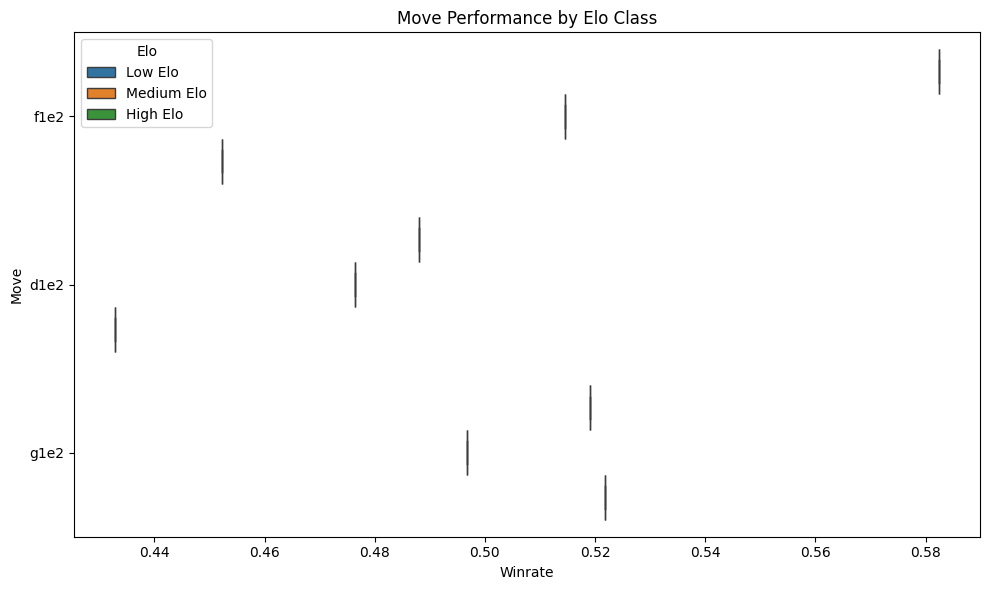

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_plot, x='winrate', y='move', hue='Elo')
plt.title('Move Performance by Elo Class')
plt.xlabel('Winrate')
plt.ylabel('Move')
plt.legend(title='Elo')
plt.tight_layout()
plt.show()


# Todo
* Grafik fixen + Scaling anpassen, das ist teilweise noch negativ, also wird wohl noch falsch berechnet
* Was der Baum ist: Durchschnittliche Elo auch interessant, jeweils die drei am häufigsten gespielten Züge, damit nicht zu überladen und noch lesbar
* passt der baum mit winrate oder sollte man auf winrate verzichten und nur auf berwertung der stellung schauen?
* vielleicht winrate nicht als entscheidungskriterium und dann als train test datensatz für z.B. 1000 stellungen ausführen und schauen ob der beste ausgewählte zug auch die höchste winrate bringt [falls ich das so mache --> winrate für elo oder gesamte??]; besten zug, der aber nicht zu komplex ist
* Macht winrate für weiß sinn? gerade beim min max scaler ja eigentlich nicht oder? weil eigentlich müsste man die zugverbesserung aus pov nehmen und daheraus entscheiden
* Komplexität vs. winrate --> ist die komplexität nicht eigentlich egal wenn der zug für eine gewisse elo in der vergangenheit sehr gute ergebnisse gelierfert hat??
* Ähnlichkeit zum Engine-Best ... sehr oft der gleiche Zug, nur falls sehr kompliziert, gibt es abweichungen
* Engine-Best auswahl teilweise komisch, da es manchmal züge mit höheren bewertungen gibt, die auch noch leichter zu spielen sind --> liegt das an Zeitbeschränkung der Suche des besten Zuges? Wie wird der beste Zug ermittelt?
* Problem: Für manche Züge zu wenige Daten, wenn nicht in exakt gleicher Stellung zuvor gespielt: prefix durch fen austauschen!!!!!!!
* Wie sieht es aus mit Quellen? Weil bisher halt effektiv 1 Quelle? Wird erwartet, dass es deutlich mehr sind 2 pro absatz mäßige
* AKTUELL WIRD IMMER AUS SICHT VON WEIß INTERPRETIERT; DAS IST QUATSCH
* Data Sparsity in Lower/Upper Elo Brackets;;;; Player Behavior and Error Patterns Across Elo Levels
* irgendwie nochmal sicherstellen, dass der count hoch genug ist, sonst neuen zug ziehen